In [ ]:
!pip install gymnasium
!pip install 'gymnasium[classic-control]'

# Introduction to Reinforcement Learning and Q-Learning

Reinforcement Learning (RL) is a type of machine learning where an agent learns to make decisions by taking actions in an environment to maximize some notion of cumulative reward. RL is defined by the interaction between an agent and its environment, which leads to a sequence of states, actions, and rewards.

## Key Concepts in Reinforcement Learning:

- **Agent**: The learner or decision maker.
- **Environment**: The system the agent interacts with.
- **State (s)**: The current situation of the agent.
- **Action (a)**: An item from the set of all possible actions.
- **Reward (R)**: An immediate return sent from the environment to assess the last action.

## Q-Learning: A Method of Reinforcement Learning

Q-Learning is a value-based RL algorithm that seeks to find the best action to take given the current state. It's focused on action-value function $Q(s, a)$, which estimates the value of taking action $a$ in state $s$.

### The Q-function:

The Q-value of a state-action pair $(s, a)$ is the expected cumulative reward of taking action a in state s, then following the optimal policy thereafter. Mathematically, it can be expressed as:

$\[ Q(s, a) = R(s, a) + \gamma \max_{a'} Q(s', a') \]$

where:
- $\(s'\)$ is the next state,
- $\(a'\)$ is the next action,
- $\(\gamma\)$ is the discount factor representing the difference in importance between future rewards and present rewards.

### The Q-learning Update Rule:

The Q-values are updated as follows:

$\[ Q(s, a) \leftarrow Q(s, a) + \alpha [R(s, a) + \gamma \max_{a'} Q(s', a') - Q(s, a)] \]$

where $\(\alpha\)$ is the learning rate.

# Introduction to Deep Q-Networks (DQN)

Deep Q-Networks (DQN) extend Q-learning by using deep neural networks to approximate the Q-value function. The key innovation of DQN is to use a convolutional neural network (CNN), to approximate the Q-value function, which can handle high-dimensional input spaces efficiently.

## The DQN Algorithm

The DQN algorithm uses a neural network to approximate the Q-value function. The input to the network is the state of the environment, and the output is the predicted Q-values for all possible actions.

### Key Components of DQN:

- **Experience Replay**: To break the correlation between consecutive samples, DQN stores the agent's experiences at each time-step, $\(e_t = (s_t, a_t, r_t, s_{t+1})\)$, in a data set called the replay buffer. Random mini-batches from the buffer are used to train the network.

- **Fixed Q-targets**: To stabilize training, DQN uses two separate networks with identical architectures. The primary network estimates the Q-values, which are updated every time step. The target network's weights are fixed and only updated with the primary network's weights every $\(N\)$ steps. This separation helps to mitigate the moving target problem.

### The Loss Function:

The loss function for DQN is defined as the mean squared error between the current Q-value estimate and the target Q-value:

$\[ L(\theta) = \mathbb{E} \left[ \left( R_{t+1} + \gamma \max_{a'} Q(s_{t+1}, a'; \theta^-) - Q(s_t, a_t; \theta) \right)^2 \right] \]$

where:
- $\(\theta\)$ represents the parameters of the primary network,
- $\(\theta^-\)$ represents the parameters of the target network.


# Experience Replay

Experience Replay is a critical component in stabilizing the training of Deep Q-Networks. It addresses the issues of correlated data and non-stationary distributions, which are prevalent in online learning scenarios.

## Concept:

In DQN, experiences at each time step \(t\), denoted as \(e_t = (s_t, a_t, r_t, s_{t+1})\), are stored in a replay buffer \(D\). The tuple consists of the current state \(s_t\), the action taken \(a_t\), the reward received \(r_t\), and the subsequent state \(s_{t+1}\).

## The Replay Buffer:

The replay buffer is a finite-sized cache. When the buffer exceeds its capacity, older experiences are removed to make room for the new ones. This process ensures a diverse set of experiences for training, preventing the model from overfitting to recent patterns.

## Training with Mini-Batches:

During training, mini-batches of experiences \((s, a, r, s')\) are sampled uniformly at random from the replay buffer. This random sampling helps to break the correlation between consecutive learning updates, stabilizing the training process.

### The Update Equation with Experience Replay:

Given a mini-batch of experiences, the Q-learning update rule in the context of DQN is applied as follows:

\[ Q(s, a; \theta) \leftarrow Q(s, a; \theta) + \alpha \left( r + \gamma \max_{a'} Q(s', a'; \theta^-) - Q(s, a; \theta) \right) \]

- \(\theta\): Current network parameters,
- \(\theta^-\): Parameters of the target network, fixed for \(N\) steps.

The use of \(\theta^-\) in calculating the max Q-value of the next state \(s'\) ensures that the target is stable, addressing the moving target problem. The parameters \(\theta\) are updated to minimize the difference between the left and right sides of this equation, typically using gradient descent methods.


In [26]:
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 2.7 MB/s eta 0:00:00


In [27]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from typing import List, Tuple

import collections
from collections import namedtuple, deque
import tqdm
import matplotlib.pyplot as plt
import random
import gymnasium as gym

from IPython.display import clear_output
from IPython import display

%matplotlib inline


Prepare environment

In this notebook, we utilize the CartPole-v0 environment in Gymnasium.

Learn more about the CartPole-v0 environment

The goal of this environment is to balance a pole by applying forces in the left and right directions on the cart. It has a discrete action space:

    0: Push cart to the left
    1: Push cart to the right

Upon taking an action, either left or right, an agent observes a 4-dimensional state consisting of:

    Cart Position
    Cart Velocity
    Pole Angle
    Pole Angular Velocity

A reward of +1 is granted to the agent at each step while the pole is kept upright. The maximum reward an agent can earn in a single episode is 200.

The episode ends under the following conditions:

    Termination: Pole Angle is greater than ±12°
    Termination: Cart Position is greater than ±2.4 (center of the cart reaches the edge of the display)
    Truncation: Episode length exceeds 200 steps

In the code below, I provide an example of the agent randomly exploring this environment over 100 time steps.


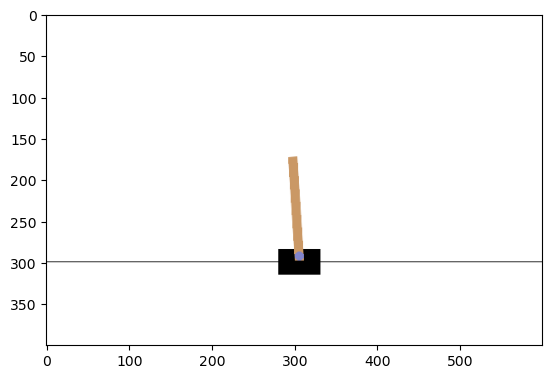

In [28]:
# Create CartPole environment
env = gym.make('CartPole-v0', render_mode='rgb_array')
state, _ = env.reset()

# Run the environment for 20 steps
for i in range(20):
    # Display the current state of the environment
    plt.imshow(env.render())
    display.display(plt.gcf())
    display.clear_output(wait=True)

    # Choose a random action from the action space
    action = env.action_space.sample()

    # Take the chosen action and observe the next state, reward, and termination status
    state, reward, terminated, truncated, info = env.step(action)

    # If the episode is terminated or truncated, reset the environment
    if terminated or truncated:
        state, info = env.reset()

# Close the environment after exploration
env.close()

In [29]:
class FullyConnectedModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(FullyConnectedModel, self).__init__()

        # Define layers with ReLU activation
        self.linear1 = nn.Linear(input_size, 16)
        self.activation1 = nn.ReLU()
        self.linear2 = nn.Linear(16, 16)
        self.activation2 = nn.ReLU()
        self.linear3 = nn.Linear(16, 16)
        self.activation3 = nn.ReLU()

        # Output layer without activation function
        self.output_layer = nn.Linear(16, output_size)

        # Initialization using Xavier uniform (a popular technique for initializing weights in NNs)
        nn.init.xavier_uniform_(self.linear1.weight)
        nn.init.xavier_uniform_(self.linear2.weight)
        nn.init.xavier_uniform_(self.linear3.weight)
        nn.init.xavier_uniform_(self.output_layer.weight)

    def forward(self, inputs):
        # Forward pass through the layers
        x = self.activation1(self.linear1(inputs))
        x = self.activation2(self.linear2(x))
        x = self.activation3(self.linear3(x))
        x = self.output_layer(x)
        return x


class QNetwork:
    def __init__(self, env, lr, logdir=None):
        # Define Q-network with specified architecture
        self.net = FullyConnectedModel(4, 2)
        self.env = env
        self.lr = lr
        self.logdir = logdir
        self.optimizer = optim.Adam(self.net.parameters(), lr=self.lr)

    def load_model(self, model_file):
        # Load pre-trained model from a file
        return self.net.load_state_dict(torch.load(model_file))

    def load_model_weights(self, weight_file):
        # Load pre-trained model weights from a file
        return self.net.load_state_dict(torch.load(weight_file))

In [30]:
class ReplayMemory:
    def __init__(self, env, memory_size=50000, burn_in=10000):
        # Initializes the replay memory, which stores transitions recorded from the agent taking actions in the environment.
        self.memory_size = memory_size
        self.burn_in = burn_in
        self.memory = collections.deque([], maxlen=memory_size)
        self.env = env

    def sample_batch(self, batch_size=32):
        # Returns a batch of randomly sampled transitions to be used for training the model.
        return random.sample(self.memory, batch_size)

    def append(self, transition):
        # Appends a transition to the replay memory.
        self.memory.append(transition)

In [31]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

class DQN_Agent:

    def __init__(self, environment_name, lr=5e-4, render=False):
        # Initialize the DQN Agent.
        self.env = gym.make(environment_name)
        self.lr = lr
        self.policy_net = QNetwork(self.env, self.lr)
        self.target_net = QNetwork(self.env, self.lr)
        self.target_net.net.load_state_dict(self.policy_net.net.state_dict())  # Copy the weight of the policy network
        self.rm = ReplayMemory(self.env)
        self.burn_in_memory()
        self.batch_size = 32
        self.gamma = 0.99
        self.c = 0

    def burn_in_memory(self):
        # Initialize replay memory with a burn-in number of episodes/transitions.
        cnt = 0
        terminated = False
        truncated = False
        state, _ = self.env.reset()
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

        # Iterate until we store "burn_in" buffer
        while cnt < self.rm.burn_in:
            # Reset environment if terminated or truncated
            if terminated or truncated:
                state, _ = self.env.reset()
                state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)

            # Randomly select an action (left or right) and take a step
            action = torch.tensor(random.sample([0, 1], 1)[0]).reshape(1, 1)
            next_state, reward, terminated, truncated, _ = self.env.step(action.item())
            reward = torch.tensor([reward])
            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)

            # Store new experience into memory
            transition = Transition(state, action, next_state, reward)
            self.rm.memory.append(transition)
            state = next_state
            cnt += 1

    def epsilon_greedy_policy(self, q_values, epsilon=0.05):
        # Implement an epsilon-greedy policy. 
        p = random.random()
        if p > epsilon:
            with torch.no_grad():
                return self.greedy_policy(q_values)
        else:
            return torch.tensor([[self.env.action_space.sample()]], dtype=torch.long)

    def greedy_policy(self, q_values):
        # Implement a greedy policy for test time.
        return torch.argmax(q_values)

    def train(self):
        # Train the Q-network using Deep Q-learning.
        state, _ = self.env.reset()
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        terminated = False
        truncated = False

        # Loop until reaching the termination state
        while not (terminated or truncated):
            with torch.no_grad():
                q_values = self.policy_net.net(state)

            # Decide the next action with epsilon greedy strategy
            action = self.epsilon_greedy_policy(q_values).reshape(1, 1)

            # Take action and observe reward and next state
            next_state, reward, terminated, truncated, _ = self.env.step(action.item())
            reward = torch.tensor([reward])
            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(next_state, dtype=torch.float32).unsqueeze(0)

            # Store the new experience
            transition = Transition(state, action, next_state, reward)
            self.rm.memory.append(transition)

            # Move to the next state
            state = next_state

            # Sample minibatch with size N from memory
            transitions = self.rm.sample_batch(self.batch_size)
            batch = Transition(*zip(*transitions))
            non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool)
            non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
            state_batch = torch.cat(batch.state)
            action_batch = torch.cat(batch.action)
            reward_batch = torch.cat(batch.reward)

            # Get current and next state values
            state_action_values = self.policy_net.net(state_batch).gather(1, action_batch) # extract values corresponding to the actions Q(S_t, A_t)
            next_state_values = torch.zeros(self.batch_size)

            with torch.no_grad():
                # no next_state_value update if an episode is terminated (next_satate = None)
                # only update the non-termination state values (Ref: https://gymnasium.farama.org/tutorials/gymnasium_basics/handling_time_limits/)
                next_state_values[non_final_mask] = self.target_net.net(non_final_next_states).max(1)[0] # extract max value

            # Update the model
            expected_state_action_values = (next_state_values * self.gamma) + reward_batch
            criterion = torch.nn.MSELoss()
            loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
            self.policy_net.optimizer.zero_grad()
            loss.backward()
            self.policy_net.optimizer.step()

            # Update the target Q-network in each 50 steps
            self.c += 1
            if self.c % 50 == 0:
                self.target_net.net.load_state_dict(self.policy_net.net.state_dict())

    def test(self, model_file=None):
        # Evaluates the performance of the agent over 20 episodes.

        max_t = 1000
        state, _ = self.env.reset()
        rewards = []

        for t in range(max_t):
            state = torch.from_numpy(state).float().unsqueeze(0)
            with torch.no_grad():
                q_values = self.policy_net.net(state)
            action = self.greedy_policy(q_values)
            state, reward, terminated, truncated, _ = self.env.step(action.item())
            rewards.append(reward)
            if terminated or truncated:
                break

        return np.sum(rewards)

  0%|          | 0/5 [00:00<?, ?it/s]

Episode: 0
The test reward for episode 0 is 78.05 with a standard deviation of 26.930419603117958.
Episode: 10
The test reward for episode 10 is 16.65 with a standard deviation of 2.1277922830953213.
Episode: 20
The test reward for episode 20 is 9.45 with a standard deviation of 0.5894913061275798.
Episode: 30
The test reward for episode 30 is 9.25 with a standard deviation of 0.5361902647381804.
Episode: 40
The test reward for episode 40 is 10.05 with a standard deviation of 0.8645808232895291.
Episode: 50
The test reward for episode 50 is 51.45 with a standard deviation of 7.4126580927491865.
Episode: 60
The test reward for episode 60 is 55.65 with a standard deviation of 12.779964788683888.
Episode: 70
The test reward for episode 70 is 62.9 with a standard deviation of 12.11981848048889.
Episode: 80
The test reward for episode 80 is 124.15 with a standard deviation of 32.1407451687107.
Episode: 90
The test reward for episode 90 is 182.75 with a standard deviation of 32.6953742905628

 20%|██        | 1/5 [00:15<01:00, 15.14s/it]

Episode: 0
The test reward for episode 0 is 10.6 with a standard deviation of 0.8602325267042626.
Episode: 10
The test reward for episode 10 is 9.3 with a standard deviation of 0.714142842854285.
Episode: 20
The test reward for episode 20 is 9.5 with a standard deviation of 0.7416198487095663.
Episode: 30
The test reward for episode 30 is 9.2 with a standard deviation of 0.5099019513592785.
Episode: 40
The test reward for episode 40 is 9.45 with a standard deviation of 0.864580823289529.
Episode: 50
The test reward for episode 50 is 9.7 with a standard deviation of 0.5567764362830022.
Episode: 60
The test reward for episode 60 is 9.3 with a standard deviation of 0.7810249675906653.
Episode: 70
The test reward for episode 70 is 9.3 with a standard deviation of 0.714142842854285.
Episode: 80
The test reward for episode 80 is 23.7 with a standard deviation of 4.001249804748511.
Episode: 90
The test reward for episode 90 is 134.95 with a standard deviation of 11.787599416335796.
Episode: 1

 40%|████      | 2/5 [00:31<00:48, 16.00s/it]

Episode: 0
The test reward for episode 0 is 9.15 with a standard deviation of 0.8529361054615991.
Episode: 10
The test reward for episode 10 is 53.25 with a standard deviation of 27.407799984675894.
Episode: 20
The test reward for episode 20 is 9.2 with a standard deviation of 0.812403840463596.
Episode: 30
The test reward for episode 30 is 9.3 with a standard deviation of 0.9.
Episode: 40
The test reward for episode 40 is 9.4 with a standard deviation of 0.8602325267042626.
Episode: 50
The test reward for episode 50 is 9.6 with a standard deviation of 0.7348469228349533.
Episode: 60
The test reward for episode 60 is 9.05 with a standard deviation of 0.7399324293474371.
Episode: 70
The test reward for episode 70 is 24.45 with a standard deviation of 4.318275118609281.
Episode: 80
The test reward for episode 80 is 61.45 with a standard deviation of 39.388418348545045.
Episode: 90
The test reward for episode 90 is 56.45 with a standard deviation of 16.335467547640015.
Episode: 100
The te

 60%|██████    | 3/5 [00:45<00:30, 15.00s/it]

Episode: 0
The test reward for episode 0 is 9.15 with a standard deviation of 0.5722761571129799.
Episode: 10
The test reward for episode 10 is 9.35 with a standard deviation of 0.7262919523166975.
Episode: 20
The test reward for episode 20 is 9.4 with a standard deviation of 0.7999999999999999.
Episode: 30
The test reward for episode 30 is 9.35 with a standard deviation of 0.8529361054615991.
Episode: 40
The test reward for episode 40 is 12.3 with a standard deviation of 1.1.
Episode: 50
The test reward for episode 50 is 9.95 with a standard deviation of 0.8046738469715541.
Episode: 60
The test reward for episode 60 is 14.7 with a standard deviation of 1.5198684153570667.
Episode: 70
The test reward for episode 70 is 84.85 with a standard deviation of 30.478311961130657.
Episode: 80
The test reward for episode 80 is 131.65 with a standard deviation of 37.21730108430755.
Episode: 90
The test reward for episode 90 is 199.35 with a standard deviation of 2.2422087324778666.
Episode: 100
T

 80%|████████  | 4/5 [01:00<00:15, 15.12s/it]

Episode: 0
The test reward for episode 0 is 10.15 with a standard deviation of 3.2446109165815247.
Episode: 10
The test reward for episode 10 is 11.55 with a standard deviation of 1.116915395184434.
Episode: 20
The test reward for episode 20 is 9.15 with a standard deviation of 0.7921489758877431.
Episode: 30
The test reward for episode 30 is 9.6 with a standard deviation of 0.8.
Episode: 40
The test reward for episode 40 is 9.25 with a standard deviation of 0.698212002188447.
Episode: 50
The test reward for episode 50 is 9.3 with a standard deviation of 0.9539392014169457.
Episode: 60
The test reward for episode 60 is 10.9 with a standard deviation of 2.643860813280457.
Episode: 70
The test reward for episode 70 is 9.3 with a standard deviation of 0.714142842854285.
Episode: 80
The test reward for episode 80 is 9.45 with a standard deviation of 0.864580823289529.
Episode: 90
The test reward for episode 90 is 9.2 with a standard deviation of 0.7483314773547882.
Episode: 100
The test re

100%|██████████| 5/5 [01:14<00:00, 14.91s/it]


Text(0, 0.5, 'Avg. Return')

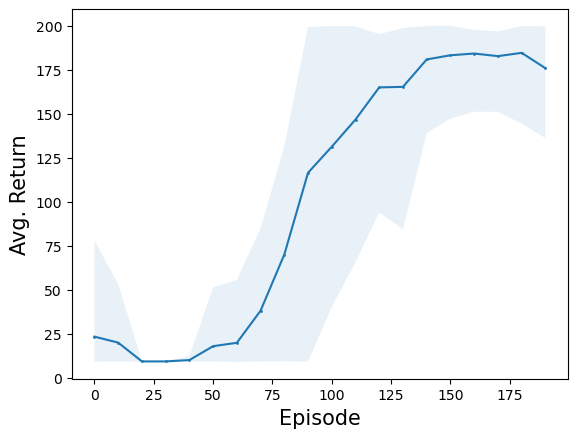

In [32]:
# Set environment and training parameters
env_name = 'CartPole-v0'
num_episodes_train = 200
num_episodes_test = 20
learning_rate = 5e-4

# Create the environment
env = gym.make(env_name)
action_space_size = env.action_space.n
state_space_size = 4

# Plot average performance of 5 trials
num_seeds = 5
l = num_episodes_train // 10
res = np.zeros((num_seeds, l))
gamma = 0.99

# Loop over multiple seeds
for i in tqdm.tqdm(range(num_seeds)):
    reward_means = []

    # Create an instance of the DQN_Agent class
    agent = DQN_Agent(env_name, lr=learning_rate)

    # Training loop
    for m in range(num_episodes_train):
        agent.train()

        # Evaluate the agent every 10 episodes during training
        if m % 10 == 0:
            print("Episode: {}".format(m))

            # Evaluate the agent's performance over 20 test episodes
            G = np.zeros(num_episodes_test)
            for k in range(num_episodes_test):
                g = agent.test()
                G[k] = g

            reward_mean = G.mean()
            reward_sd = G.std()
            print(f"The test reward for episode {m} is {reward_mean} with a standard deviation of {reward_sd}.")
            reward_means.append(reward_mean)

    res[i] = np.array(reward_means)

# Plotting the average performance
ks = np.arange(l) * 10
avs = np.mean(res, axis=0)
maxs = np.max(res, axis=0)
mins = np.min(res, axis=0)

plt.fill_between(ks, mins, maxs, alpha=0.1)
plt.plot(ks, avs, '-o', markersize=1)

plt.xlabel('Episode', fontsize=15)
plt.ylabel('Avg. Return', fontsize=15)

In [38]:
# Create CartPole environment
env = gym.make('CartPole-v0', render_mode='human')
state, _ = env.reset()

# Run the environment for 100 steps
for i in range(250):
    # Display the current state of the environment
    if env.render_mode == "rgb_array":
        plt.imshow(env.render())
        display.display(plt.gcf())
        display.clear_output(wait=True)
    else:
        env.render()

    # Choose an action based on the learned Q-network
    state = torch.from_numpy(state).float().unsqueeze(0)
    with torch.no_grad():
        q_values = agent.policy_net.net(state)
    action = agent.greedy_policy(q_values).detach().numpy()

    # Take the chosen action and observe the next state, reward, and termination status
    state, reward, terminated, truncated, _ = env.step(action)

    # If the episode is terminated or truncated, reset the environment
    if terminated or truncated:
        state, info = env.reset()

# Close the environment after exploration
env.close()